# Homework 4

# Задача №1 - Хвост кита

Не так давно на kaggle было соревнование по классификации горбатых китов по снимках их хвостов. Одним из приемов для улучшения работы нейронной сети было выделение маски хвоста. Затем по этой маске вырезался хвост на исходном изображении, нормировался, отображался на черный фон и подавался нейронной сети на вход. 

Ваша задача - написать программу, которая совершит предобработку картинки, описанную выше. Т.е. найти маску хвоста, по маске вырезать из исходного изображения хвост, нормировать изображение хвоста так, чтобы оно всегда имело один заданный размер и равномерно занимало место, то есть, если хвост был повернут, его нужно выпрямить.

Изображения хвостов находятся в папке whale_tail/images к этому занятию. Разметка картинок (маски хвостов) лежат в папке whale_tail/ground_truth. После выделения хвоста посчитайте IoU для каждой картинки (ипсользуя маски из whale_tail/ground_truth)

<table><tr>
    <td> <img src="whale_tail/images/test_image_01.jpg" alt="Drawing" style="width: 400px;"/> 
    <td> <img src="whale_tail/ground_truth/test_image_01.png" alt="Drawing" style="width: 400px;"/> </td>
  
</tr></table>

# IoU 
 Intercetion over union - число от 0 до 1, показывающее, насколько у двух объектов (эталонного (ground true) и текущего) совпадает внутренний “объем”.
 
<table><tr>
    <td> <img src="../img/iou.png" alt="Drawing" style="width: 400px;"/> 
  
</tr></table>

In [1]:
import numpy as np
import pylab
import cv2
import os

In [9]:
def normalize_image(img):
    img = np.array(img, dtype = np.float32)
    return (img - img.min())/(img.max() - img.min())

In [11]:
sigma=0.33


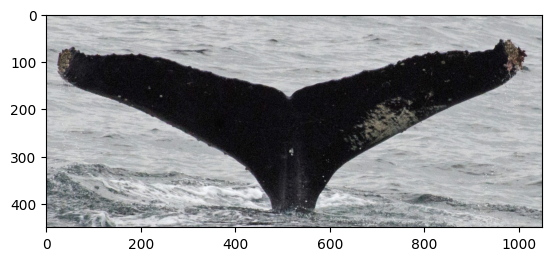

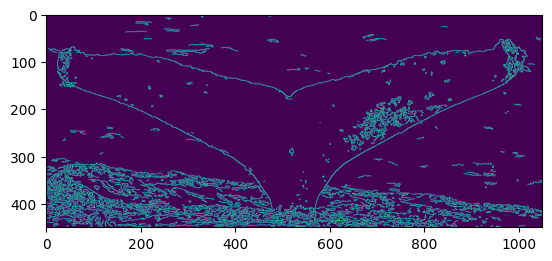

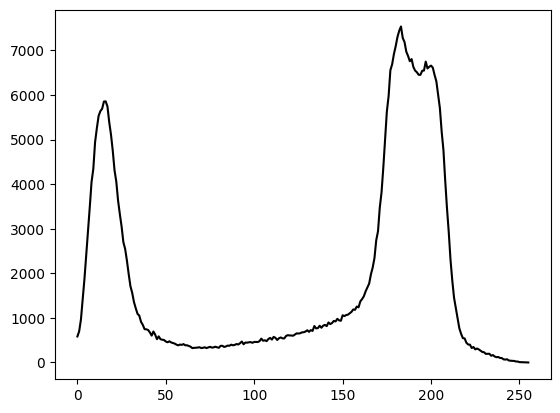

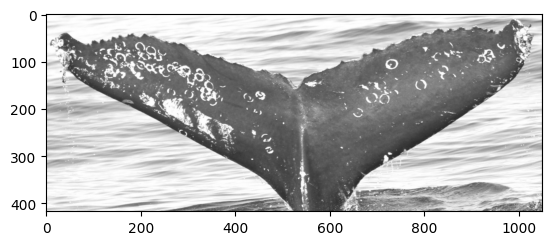

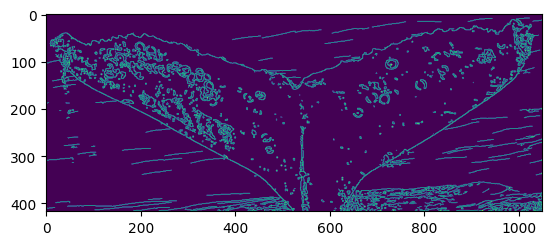

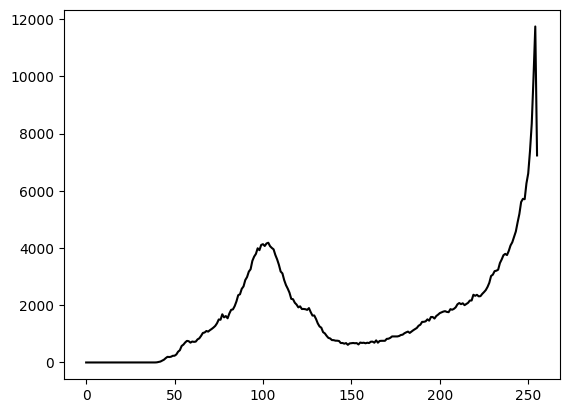

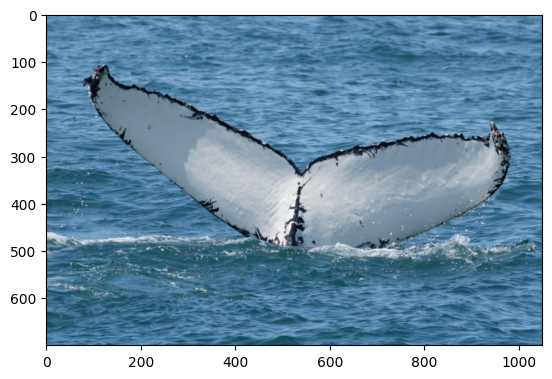

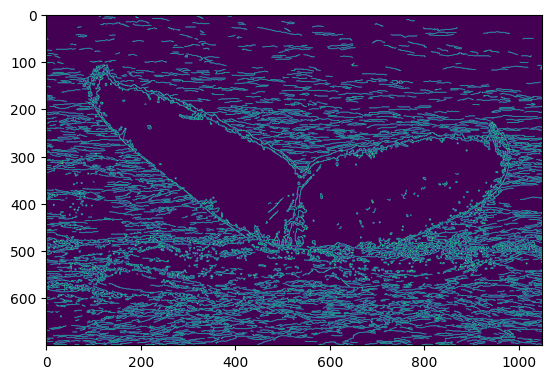

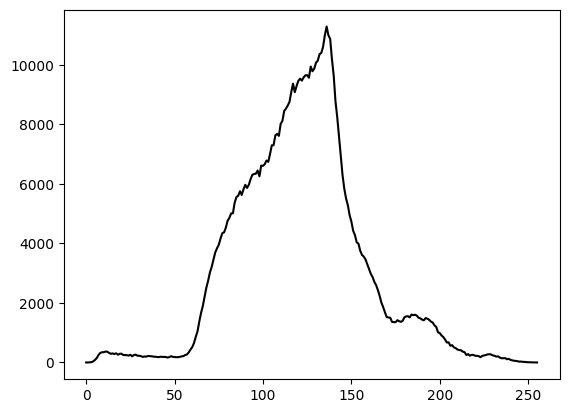

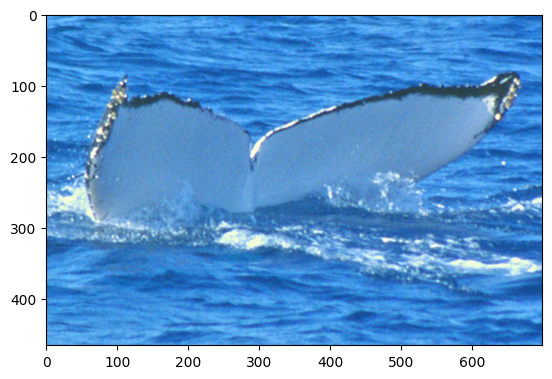

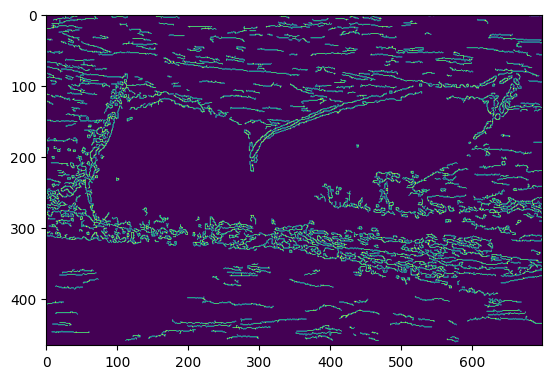

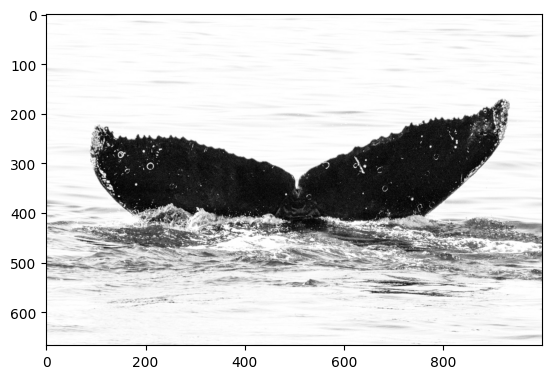

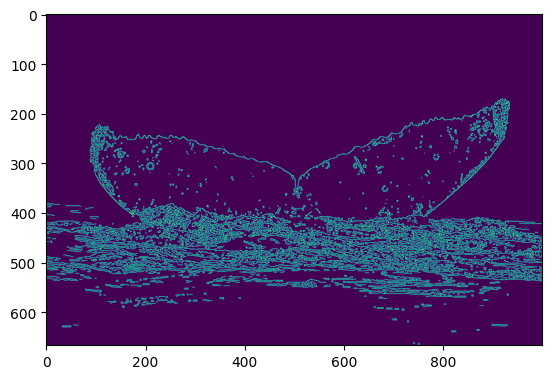

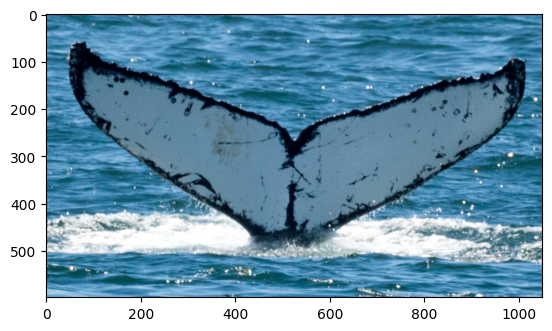

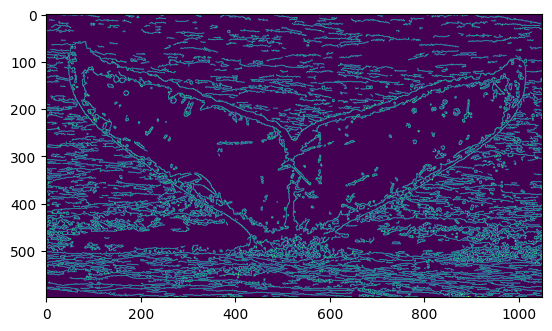

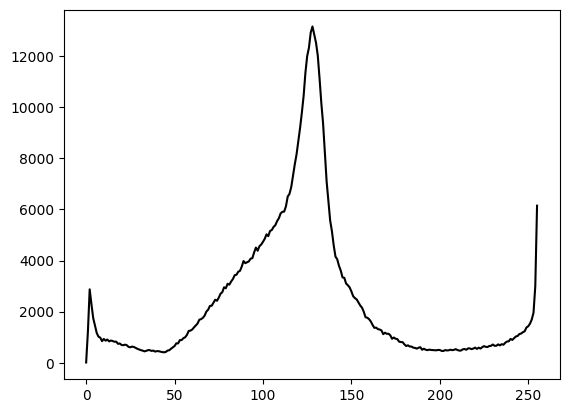

In [22]:
# Ваш код
for elm in os.listdir("whale_tail/images"):
    img = cv2.imread(f'whale_tail/images/{elm}')
    if img is not None:
        # img = normalize_image(img)
        pylab.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        pylab.show()
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        v = np.median(img_gray)
        # apply automatic Canny edge detection using the computed median
        lower = int(max(0, (1.0 - sigma) * v))
        upper = int(min(255, (1.0 + sigma) * v))
        img_grad = cv2.Canny(img_gray, lower, upper)
        # img_grad = normalize_image(img_grad)
        pylab.imshow(img_grad)
        pylab.show()

        hist_full = cv2.calcHist([img_gray], [0], None, [256], [0,256])
        pylab.plot(hist_full, color="black", label=f'{"blue"} channel')
        pylab.show()
        

# Задача №2 - Найти шаблон на изображении с помощью HOG и кросс-корреляции

Ваша задача - написать программу, которая сможет найти шаблон одного глаза на нескольких изображениях, в том числе затемненных. Использовать нужно HOG представление изображений, поиск шаблона сделать с помощью кросс-корреляции 

Изображение глаз человека и шаблон, который нужно на нем найти, находятся в папке hog

<table><tr>
    <td> <img src="hog/eye.png" alt="Drawing" style="width: 400px;"/> 
</tr></table>     

<table><tr>
    <td> <img src="hog/eyes.jpg" alt="Drawing" style="width: 400px;"/> </td>
      <td> <img src="hog/eyes_dark.jpg" alt="Drawing" style="width: 400px;"/> </td>
      <td> <img src="hog/woman.jpg" alt="Drawing" style="width: 200px;"/> </td>

</tr></table>

In [2]:
from skimage.feature import hog

In [3]:
from tqdm import tqdm
def normalized_cross_correlation(f, g): # кросс-корреляция из второй лабы

    Hf, Wf = f.shape
    Hg, Wg = g.shape
    
    out = np.zeros_like(f, dtype = float)
    # ### YOUR CODE HERE
    g_mean = np.mean(g)
    g_std = np.std(g)
    g = g - g_mean
    print(f"template mean value (after correction) : {np.mean(g)}")
    for m in tqdm(range(Hf - Hg)):
        for n in range(Wf - Wg):
            
            matr_frag = f[m : m + Hg, n : n + Wg]
            matr_mean = np.mean(matr_frag)
            matr_std = np.std(matr_frag)
            matr_frag = matr_frag - matr_mean

            elm_matr = np.multiply(g, matr_frag)
            
            out[m,n] = np.sum(elm_matr) / (matr_std * g_std)

    ### END YOUR CODE

    return out

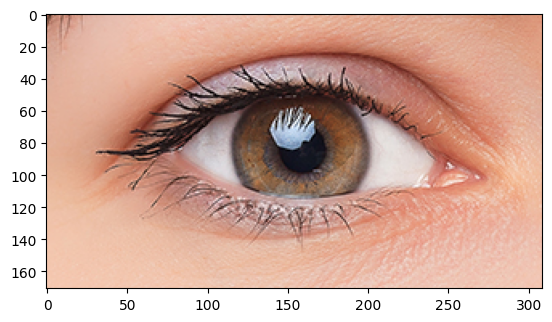

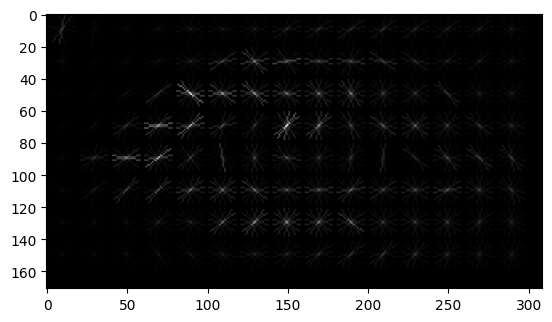

In [5]:
tmp = cv2.imread(f'hog/eye.png')

pylab.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))
pylab.show()
fd, hog_tmp = hog(tmp, orientations=8, pixels_per_cell=(20, 20),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)
pylab.imshow(hog_tmp, cmap=pylab.cm.gray)
pylab.show()

### Обычные глаза

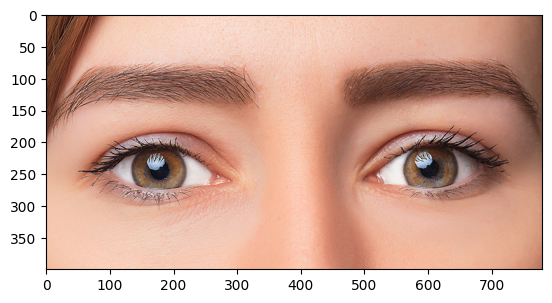

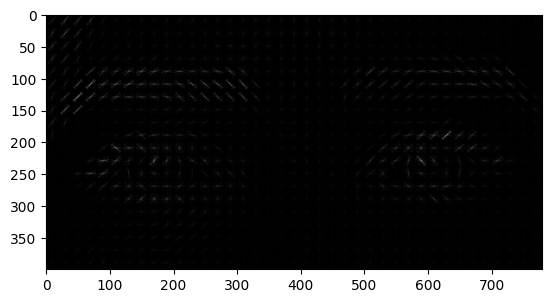

In [8]:
img = cv2.imread(f'hog/eyes.jpg')

# img = normalize_image(img)
pylab.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
pylab.show()
fd, hog_img = hog(img, orientations=8, pixels_per_cell=(20, 20),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)
pylab.imshow(hog_img, cmap=pylab.cm.gray)
pylab.show()

In [10]:
res = normalized_cross_correlation(hog_img, hog_tmp)

template mean value (after correction) : 5.163769384959565e-17


100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [00:40<00:00,  5.66it/s]


In [11]:
y, x = np.unravel_index(res.argmax(), res.shape)
y += (tmp.shape[0] / 2)
x += (tmp.shape[1] / 2)

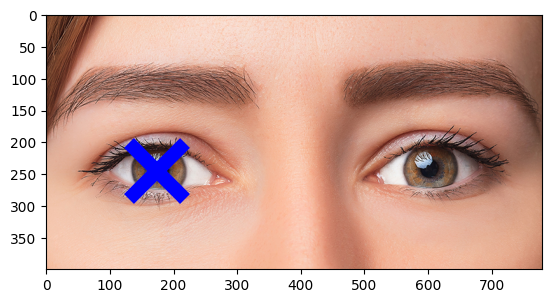

In [13]:
pylab.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
pylab.plot(x, y, 'bx', ms=40, mew=10)
pylab.show()

### Темные глаза

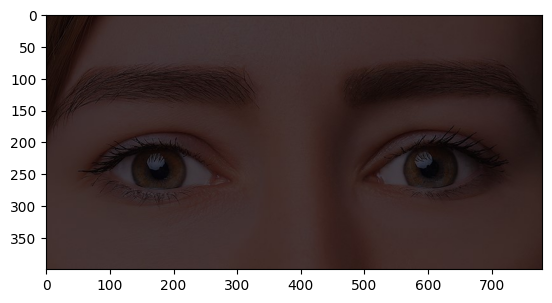

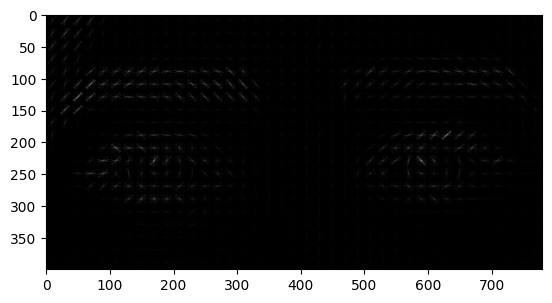

In [14]:
img = cv2.imread(f'hog/eyes_dark.jpg')

# img = normalize_image(img)
pylab.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
pylab.show()
fd, hog_img = hog(img, orientations=8, pixels_per_cell=(20, 20),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)
pylab.imshow(hog_img, cmap=pylab.cm.gray)
pylab.show()

In [15]:
res = normalized_cross_correlation(hog_img, hog_tmp)

template mean value (after correction) : 5.163769384959565e-17


100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [00:37<00:00,  6.15it/s]


In [16]:
y, x = np.unravel_index(res.argmax(), res.shape)
y += (tmp.shape[0] / 2)
x += (tmp.shape[1] / 2)

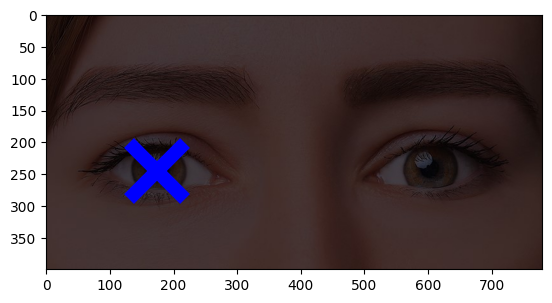

In [17]:
pylab.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
pylab.plot(x, y, 'bx', ms=40, mew=10)
pylab.show()


### Женщина

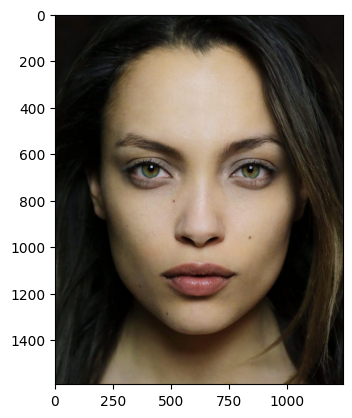

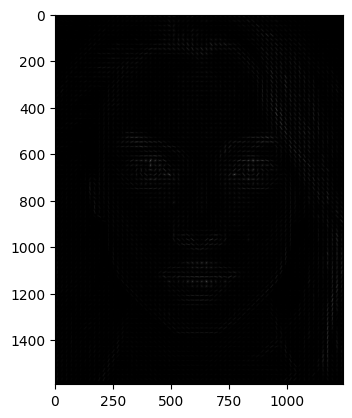

In [18]:
img = cv2.imread(f'hog/woman.jpg')

# img = normalize_image(img)
pylab.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
pylab.show()
fd, hog_img = hog(img, orientations=8, pixels_per_cell=(20, 20),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)
pylab.imshow(hog_img, cmap=pylab.cm.gray)
pylab.show()

In [19]:
res = normalized_cross_correlation(hog_img, hog_tmp)

template mean value (after correction) : 5.163769384959565e-17


100%|██████████████████████████████████████████████████████████████████████████████| 1420/1420 [07:39<00:00,  3.09it/s]


In [20]:
y, x = np.unravel_index(res.argmax(), res.shape)
y += (tmp.shape[0] / 2)
x += (tmp.shape[1] / 2)

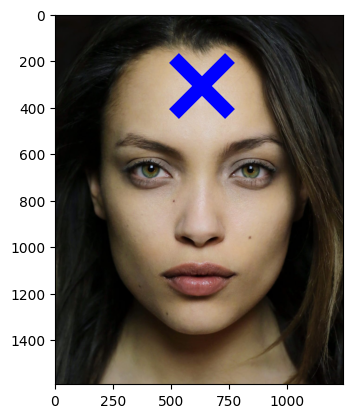

In [21]:
pylab.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
pylab.plot(x, y, 'bx', ms=40, mew=10)
pylab.show()
